## <center>Scrits to generate figure 2 in r2d4 manuscript</center>


In [29]:
%matplotlib inline
import scipy
import pdb

from pylab import *
import scipy.cluster.hierarchy as sch
import numpy as np
import fnmatch
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from matplotlib.colors import rgb2hex, colorConverter
from scipy.spatial import distance
from scipy import signal
os.chdir(os.path.expanduser('~/Dropbox/r2d4/Covariance_Analysisv4/'))
import pdb

## <center>Do hierarchical clustering and Frobenious norm calculations </center>

In [30]:
#Create DataFrame for summary cluster statisitcs for each day

def initialize_dfs():
    trueDistances = np.array([[0, 0.0896, 0.0896, 0.3134],[0,0,0.3134,0.0896], [0,0,0,0.1045], [0,0,0,0]])
    index = range(0,25)
    df_ = pd.DataFrame(index=index)
    df_.index.name = 'Day'
    df_ = df_.fillna(np.nan) # with 0s rather than NaNs
    dfMah = pd.DataFrame(index=index)
    dfMah = dfMah.fillna(np.nan) # with 0s rather than NaNs
    dfMah.index.name = 'Day'  
    return dfMah, df_

def buildHierarchy(subjectDir, group):
 
    # Find files matching
    summary_files = []
    for file in os.listdir(subjectDir):
        if fnmatch.fnmatch(file, 'Day_*.csv'):
            summary_files.append(os.path.realpath(os.path.join(subjectDir,file)))

    k=1
    for file in summary_files:
        base=os.path.basename(file)
        fig = plt.figure(figsize=(8,8))
        D = np.genfromtxt(file, delimiter=',')

        # Compute and plot first dendrogram.
        ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
        Y = sch.linkage(D, method='single')
        Z1 = sch.dendrogram(Y, orientation='left', color_threshold=.97, above_threshold_color= '.75', leaf_font_size=.2)
        ax1.set_xticks([])

        # Compute and plot second dendrogram.
        ax2 = fig.add_axes([0.3,0.71,0.6,0.2])
        Y = sch.linkage(D, method='single') #i.e Y is linkage matrix
    
        Z2 = sch.dendrogram(Y, color_threshold=.97 , above_threshold_color= '.75', leaf_font_size=.2)
        sns.set_palette('Set1', 10, 0.65)
        palette = sns.color_palette()
        sch.set_link_color_palette(['black'])
        ax2.set_xticks([])
        plt.ylabel('Distance')

        # Plot distance matrix.
        axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
        idx1 = Z1['leaves']
        idx2 = Z2['leaves']
        D = D[idx1,:]
        D = D[:,idx2]
        im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.Blues_r, vmin=.5, vmax=1)
        axmatrix.set_xticks([])
        axmatrix.set_yticks([])
        axmatrix.set_xticks(range(32))
        axmatrix.set_xticklabels(idx1, minor=False)
        axmatrix.xaxis.set_label_position('bottom')
        axmatrix.xaxis.tick_bottom()
        axmatrix.xaxis.set_label('Sequence Position')
        plt.xticks(rotation=-90, fontsize=8)

        axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
        plt.colorbar(im, cax=axcolor)
        fig.show()

        axmatrix.xaxis.tick_bottom()

        plt.xticks(rotation=90, fontsize=4)
        base=os.path.basename(file)
        daytemp = os.path.splitext(base)[0]
        day = int(daytemp[4:])
        subject = subjectDir[-4:]
        fn = subjectDir + '/'+ os.path.splitext(base)[0] + '.svg'
        fig.savefig(fn)
        plt.clf()

        Y = Y[np.where(Y[:,3] == 2)]
        df = pd.DataFrame(Y)
        dict = {0:4, 1:5,  2:3, 3:4,  4:2, 5:5, 6:3, 7: 2,8:4, 9:5, 10:4, 11:5, 12:2, 13:4, 14:5, 15:3, 16:2, \
                17:3, 18: 5, 19:3, 20: 4,21:2, 22:3, 23:2, 24: 3, 25:5, 26: 4,27:2, 28:4, 29:2, 30:3, 31:5}
        df['Key1'] = df[0].map(dict)
        df['Key2'] = df[1].map(dict)
        b = np.zeros((4,4))
          
        b[0,1] = np.mean(df.loc[((df['Key1']==2) & (df['Key2']==3)) | ((df['Key1']==3) & (df['Key2']==2)) ,2])
        b[0,2] = np.mean(df.loc[((df['Key1']==2) & (df['Key2']==4)) | ((df['Key1']==4) & (df['Key2']==2)) ,2])
        b[0,3] = np.mean(df.loc[((df['Key1']==2) & (df['Key2']==5)) | ((df['Key1']==5) & (df['Key2']==2)) ,2])
        b[1,2] = np.mean(df.loc[((df['Key1']==3) & (df['Key2']==4)) | ((df['Key1']==4) & (df['Key2']==3)) ,2])
        b[1,3] = np.mean(df.loc[((df['Key1']==3) & (df['Key2']==5)) | ((df['Key1']==5) & (df['Key2']==3)) ,2])
        b[2,3] = np.mean(df.loc[((df['Key1']==4) & (df['Key2']==5)) | ((df['Key1']==5) & (df['Key2']==4)) ,2])
        where_are_NaNs = np.isnan(b)
        b[where_are_NaNs] = 0
        df_.loc[day-1, subject] = np.nanmean(b[np.nonzero(b)])
        dfMah.loc[day-1, subject] = np.linalg.norm(trueDistances-b)
        bdf = pd.DataFrame(b)
        sns.heatmap(b, annot=True, fmt='.3f', linewidths=.5, cmap = plt.cm.Blues, vmin=0, vmax=1.5)
        fn = subjectDir + '/'+ os.path.splitext(base)[0] + 'distances.svg'
        fig.savefig(fn)
        plt.close()
        
        dfMah.to_csv(group+'Mah.csv')                                                                                                                                        
        df_.to_csv(group+'Clusters.csv')
    
dfMah, df_ = initialize_dfs()   
for root, dirs, files in os.walk(os.path.expanduser('~/Dropbox/r2d4/Covariance_Analysisv4/control/')):
    buildHierarchy(root,  'control')

dfMah, df_ = initialize_dfs()
for root, dirs, files in os.walk(os.path.expanduser('~/Dropbox/r2d4/Covariance_Analysisv4/sequence/')):
    buildHierarchy(root, 'sequence')


## <center>Plot True Distance Matrix </center>

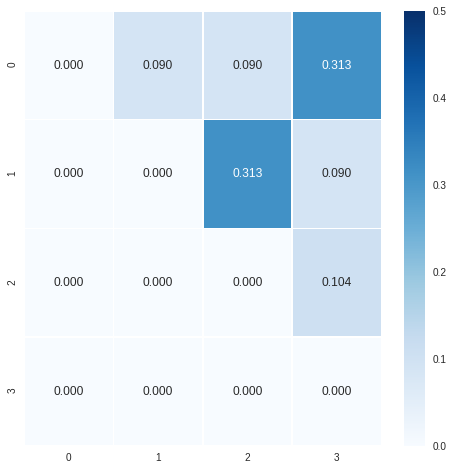

In [18]:
# sequence_stims = [4,5,3,4,2,5,3,2,4,5,4,5,2,4,5,3,2,3,5,3,4,2,3,2,3,5,4,2,4,2,3,5]
fig = plt.figure(figsize=(8,8))
trueDistances = np.array([[0, 0.0896, 0.0896, 0.3134],[0,0,0.3134,0.0896], [0,0,0,0.1045], [0,0,0,0]])
trueD = sns.heatmap(trueDistances, annot=True, fmt='.3f', linewidths=.5, cmap = plt.cm.Blues, vmin=0, vmax=.5)
fig.savefig(os.path.expanduser('~/Dropbox/r2d4/Covariance_Analysisv4/trueDistanceMatrix.svg'))                                                                                                                                           


## <center>Plot Frobenious Norm (True-Observed) for both groups </center>

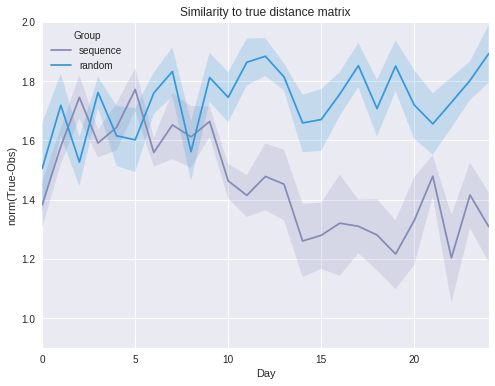

In [32]:
df = pd.read_csv('~/Dropbox/r2d4/Covariance_Analysisv4/sequenceMah.csv')
del df['rage']
df = pd.melt(df, id_vars=["Day"], var_name="subject")
df['Group'] = np.array('sequence')
df2 = pd.read_csv('~/Dropbox/r2d4/Covariance_Analysisv4/controlMah.csv')
del df2['rage']
df2 = pd.melt(df2, id_vars=["Day"], var_name="subject")
df2['Group'] = np.array('random')
bigdata=df.append(df2,ignore_index = True)
plt.figure(figsize=[8,6])
ax = sns.tsplot(data=bigdata, time="Day", unit="subject",ci=68, value="value", condition="Group",estimator=np.nanmean, interpolate = True, color=['#848BB6', '#3498DB'])
ax.set(xlabel='Day', ylabel='norm(True-Obs)')
ax.set(title= 'Similarity to true distance matrix')
ax.set(ylim=(.9, 2.0))
plt.savefig(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure2/frobnorm_SeqCon.svg'))


## <center>Plot Distance between clusters </center>

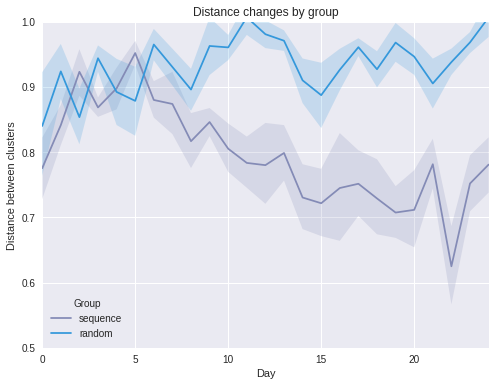

In [33]:
plt.figure(figsize=[8,6])
df = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/Covariance_Analysisv4/sequenceClusters.csv'))
del df['rage']
df = pd.melt(df, id_vars=["Day"], var_name="subject")
df['Group'] = np.array('sequence')
    
df2 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/Covariance_Analysisv4/controlClusters.csv'))
del df2['rage']
df2 = pd.melt(df2, id_vars=["Day"], var_name="subject")
df2['Group'] = np.array('random')

bigdata=df.append(df2,ignore_index = True)
ax = sns.tsplot(data=bigdata, time="Day", unit="subject", value="value",ci = 68, condition="Group",estimator=np.nanmean, interpolate = True, color=['#848BB6', '#3498DB'])
ax.set(xlabel='Day', ylabel='Distance between clusters')
ax.set(title= 'Distance changes by group')
ax.set(ylim=(.5, 1))
plt.savefig(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure2/clusterDist_SeqCon.svg'))

## <center> Plot the raw distances with sequential ordering </center>

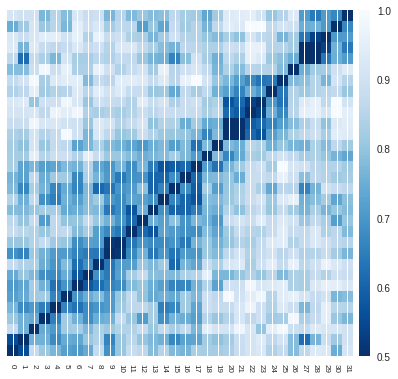

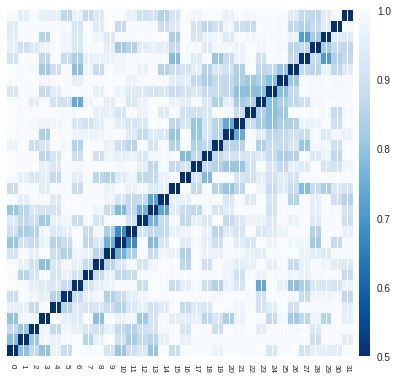

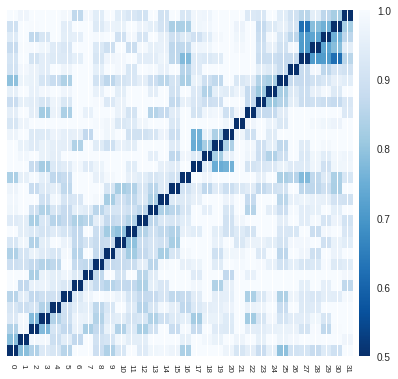

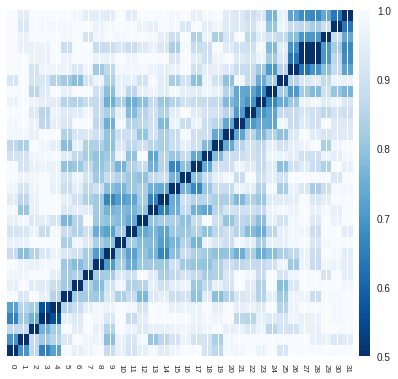

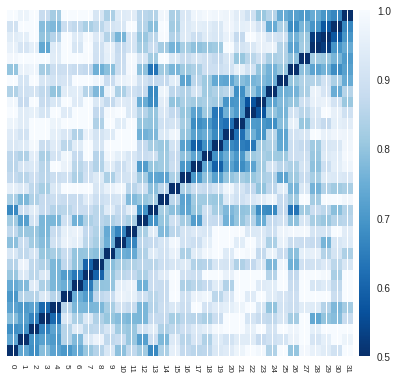

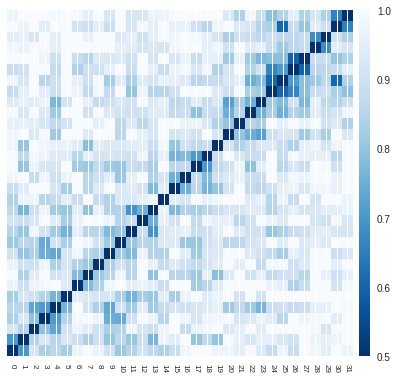

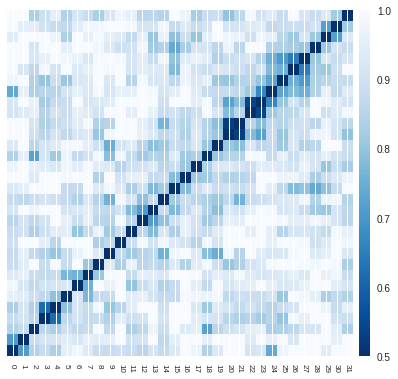

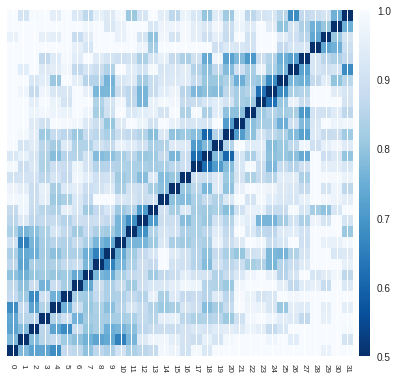

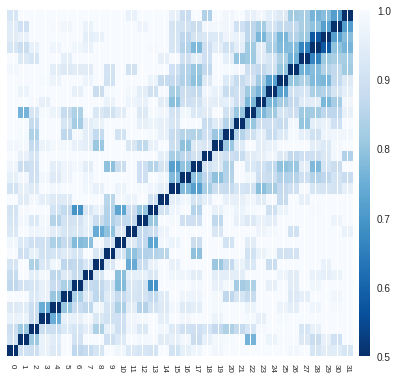

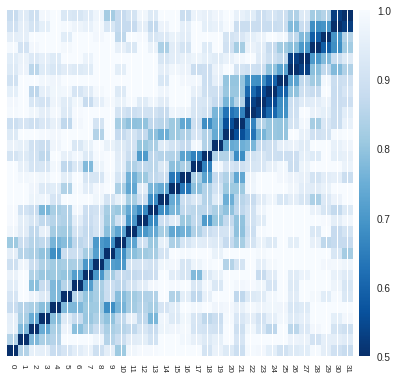

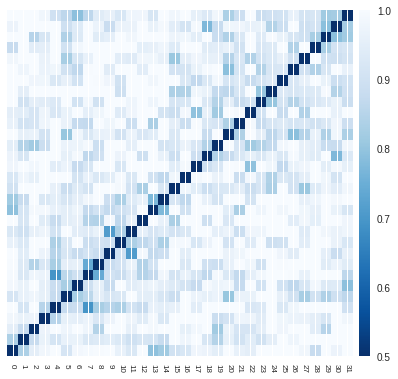

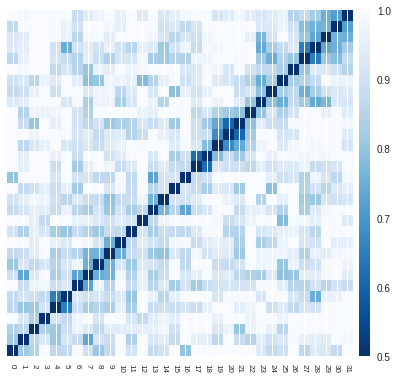

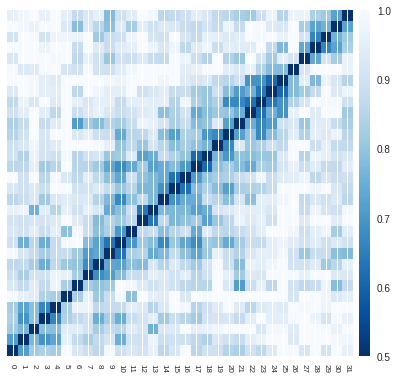

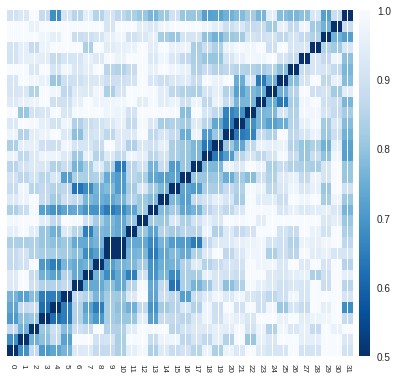

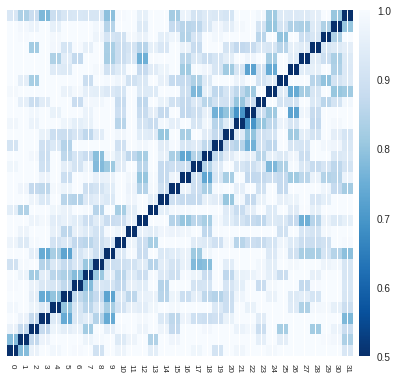

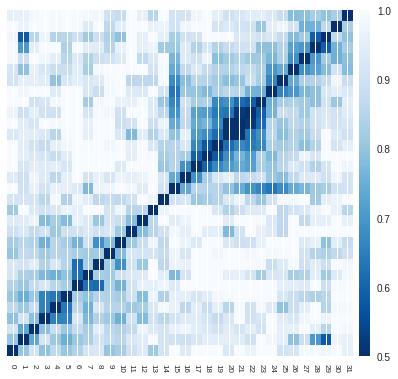

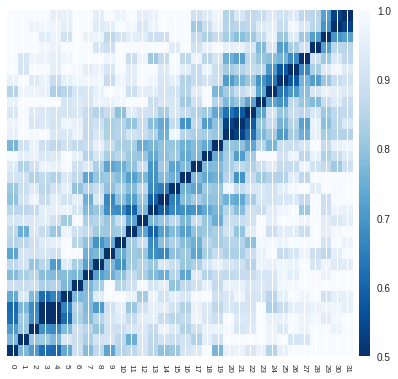

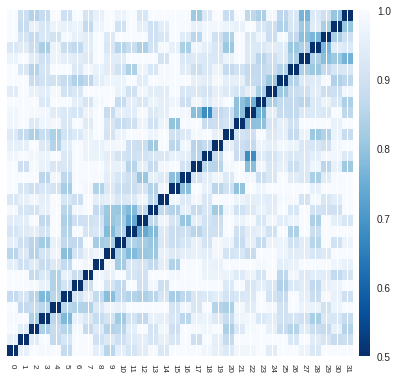

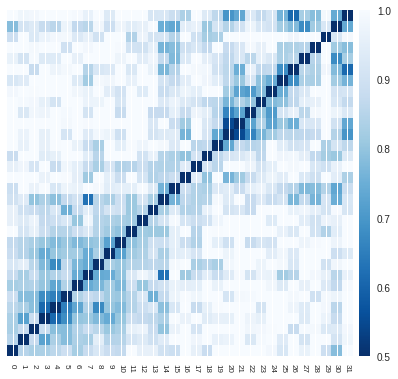

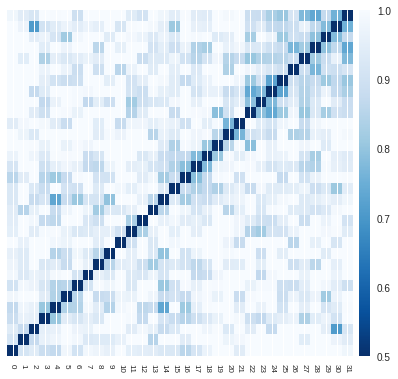

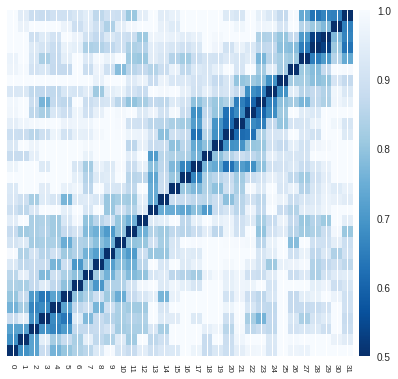

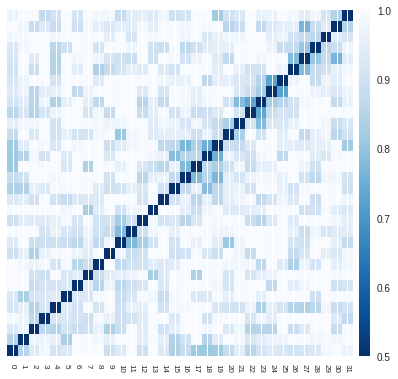

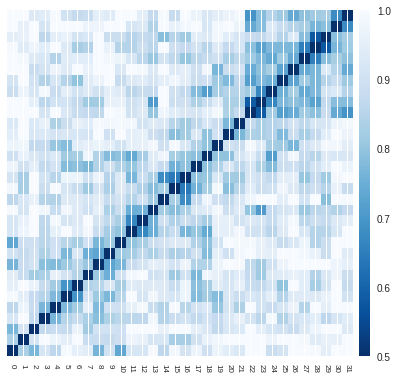

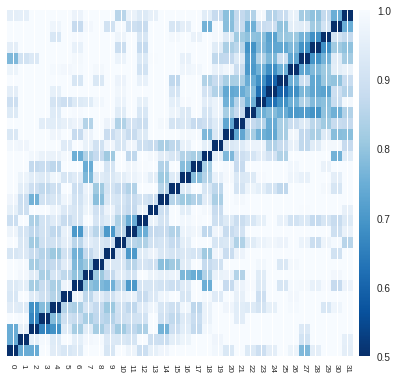

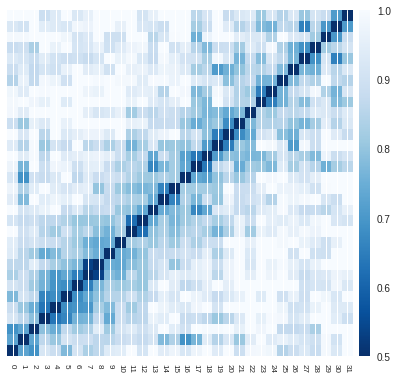

In [34]:
#Create DataFrame for summary cluster statisitcs for each day
#Subject Ids for reference. 
#Consider http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html
index = range(0,25)
df_ = pd.DataFrame(index=index)
df_.index.name = 'Day'
df_ = df_.fillna(np.nan) # with 0s rather than NaNs
dfMah = pd.DataFrame(index=index)
dfMah = dfMah.fillna(np.nan) # with 0s rather than NaNs
dfMah.index.name = 'Day'
trueDistances = np.array([[0, 0.0896, 0.0896, 0.3134],[0,0,0.3134,0.0896], [0,0,0,0.1045], [0,0,0,0]])
                                                                                                                                   
def buildHierarchy(subjectDir):
  
    #Find files matching
    summary_files = []
    for file in os.listdir(subjectDir):
        if fnmatch.fnmatch(file, 'Day_*.csv'):
            summary_files.append(os.path.realpath(os.path.join(subjectDir,file)))
    k=1
    for file in summary_files:
        base=os.path.basename(file)
        daytemp = os.path.splitext(base)[0]
        day = int(daytemp[4:])
        #only plot for first and last day
        fig = plt.figure(figsize=(8,8))
        D = np.genfromtxt(file, delimiter=',')
        # Plot distance matrix.
        axmatrix = fig.add_axes([0.3,0.1,0.6,0.6])
        im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=plt.cm.Blues_r, vmin=.5,vmax=1.0)
        axmatrix.set_xticks([])
        axmatrix.set_yticks([])
        axmatrix.set_xticks(range(32))
        axmatrix.xaxis.set_label_position('bottom')
        axmatrix.xaxis.tick_bottom()
        axmatrix.xaxis.set_label('Sequence Position')
        plt.xticks(rotation=-90, fontsize=8)
        axcolor = fig.add_axes([0.91,0.1,0.02,0.6])
        plt.colorbar(im, cax=axcolor)
        fig.show()
        axmatrix.xaxis.tick_bottom()
        plt.xticks(rotation=90, fontsize=4)
        subject = subjectDir[-4:]
        fn = subjectDir + '/'+ os.path.splitext(base)[0] + '.svg'
        if(day ==1 or day == 24):
            fn = '/home/beukema2/Dropbox/r2d4/finalfigures/Figure2/day_' + str(day) + '.svg'
            fig.savefig(fn)
for root, dirs, files in os.walk(os.path.expanduser('~/Dropbox/r2d4/Covariance_Analysisv4/sequence/average')):
    buildHierarchy(root)


In [ ]:
#Create DataFrame for summary cluster statistics for each day
#Subject Ids for reference. 
#Consider http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html
index = range(0,25)

df_ = pd.DataFrame(index=index)
df_.index.name = 'Day'
df_ = df_.fillna(np.nan) # with 0s rather than NaNs

dfrts = pd.DataFrame(index=index)
dfrts = dfrts.fillna(np.nan) # with 0s rather than NaNs
dfrts.index.name = 'Day'

def analyzeRts(subjectDir, group):
  
      #Find files matching
    summary_files = []
    for file in os.listdir(subjectDir):
        if fnmatch.fnmatch(file, '*Day_*.csv'):
            summary_files.append(os.path.realpath(os.path.join(subjectDir,file)))

    k=1
    for file in summary_files:
        df = pd.read_csv(file)
        base=os.path.basename(file)
        daytemp = os.path.splitext(base)[0]
        day = int(daytemp[48:])
        subject = subjectDir[-4:]
        dfrts.loc[day-1, subject] = (df['rt_all'][5] - df['rt_all'][6])/df['sdRT'][5]
        dfrts.to_csv(group+'reactionZscores.csv')                                                                                                                                        
   

for root, dirs, files in os.walk('/Users/plb/Dropbox/r2d4/reactionTimeFigures/sequence/'):
    analyzeRts(root, 'sequence')
    
for root, dirs, files in os.walk('/Users/plb/Dropbox/r2d4/reactionTimeFigures/control/'):
    analyzeRts(root, 'control')    


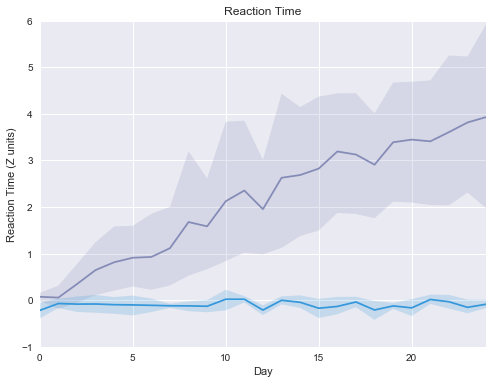

In [67]:

plt.figure(figsize=[8,6])
df = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/reactionTimeFigures/sequencereactionZscores.csv'))
df = pd.melt(df, id_vars=["Day"], var_name="subject")
df['Group'] = np.array('sequence')
    
df2 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/reactionTimeFigures/controlreactionZscores.csv'))
df2 = pd.melt(df2, id_vars=["Day"], var_name="subject")
df2['Group'] = np.array('random')
bigdata=df.append(df2,ignore_index = True)
ax = sns.tsplot(data=bigdata, time="Day", unit="subject",ci=95, value="value", condition="Group",estimator=np.nanmean, interpolate = True, color=['#848BB6', '#3498DB'])
ax.set(xlabel='Day', ylabel='Reaction Time (Z units)')
ax.set(title= 'Reaction Time')
ax.set(ylim=(-1, 6))
ax.legend_.remove()
plt.savefig(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure1/reactionTimes.svg'))


In [173]:
#Create DataFrame for summary cluster statisitcs for each day
#Subject Ids for reference. 
#columns = ['0006','0012', '0192', '0273','0490', '0491', '0557', '0558', '0559']
columns = ['0269','0464', '0494', '0495','0549', '0550', '0604', '0605', '0627']
#Consider http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html
index = range(0,25)

df_ = pd.DataFrame(index=index)
df_.index.name = 'Day'
df_ = df_.fillna(np.nan) # with 0s rather than NaNs

dfrts = pd.DataFrame(index=index)
dfrts = dfrts.fillna(np.nan) # with 0s rather than NaNs
dfrts.index.name = 'Day'

def analyzeRts(subjectDir, group):
  
      #Find files matching
    summary_files = []
    for file in os.listdir(subjectDir):
        if fnmatch.fnmatch(file, '*Day_*.csv'):
            summary_files.append(os.path.realpath(os.path.join(subjectDir,file)))

    k=1
    for file in summary_files:
        df = pd.read_csv(file)
        base=os.path.basename(file)
        daytemp = os.path.splitext(base)[0]
        day = int(daytemp[48:])
        subject = subjectDir[-4:]
        dfrts.loc[day-1, subject] = df['accuracy'][6]
        dfrts.to_csv(group+'accuracy.csv')                                                                                                                                        
        #df_.to_csv(group+'Clusters.csv')
    
        
#for root, dirs, files in os.walk('/home/beukema2/Dropbox/r2d4/Covariance_Analysisv2/control/'):
#    buildHierarchy(root,  'control')
    
#for root, dirs, files in os.walk('/home/beukema2/Dropbox/r2d4/reactionTimeFigures/sequence/'):
#    analyzeRts(root, 'sequence')
    
for root, dirs, files in os.walk('/home/beukema2/Dropbox/r2d4/reactionTimeFigures/control/'):
    analyzeRts(root, 'control')    

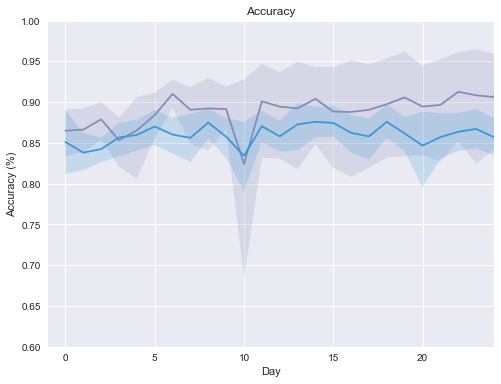

In [69]:
plt.figure(figsize=[8,6])
df = pd.read_csv('~/Dropbox/r2d4/reactionTimeFigures/sequenceaccuracy.csv')
df = pd.melt(df, id_vars=["Day"], var_name="subject")
df['Group'] = np.array('sequence')
    
df2 = pd.read_csv('~/Dropbox/r2d4/reactionTimeFigures/controlaccuracy.csv')
df2 = pd.melt(df2, id_vars=["Day"], var_name="subject")
df2['Group'] = np.array('random')

bigdata=df.append(df2,ignore_index = True)
ax = sns.tsplot(data=bigdata, time="Day", unit="subject", value="value", condition="Group",estimator=np.nanmean, interpolate = True, color=['#848BB6', '#3498DB'], err_style='ci_band', ci=95)
ax.set(xlabel='Day', ylabel='Accuracy (%)')
ax.set(title= 'Accuracy')
ax.set(ylim=(0.6,1))
ax.set(xlim=(-1,24))
ax.legend_.remove()
plt.savefig(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure1/accuracy.svg'))

## Code to generate Lags

In [ ]:
#code to generate lags. 
#Create DataFrame for summary cluster statisitcs for each day
#Consider http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.spatial.distance.pdist.html
index = range(0,32)

df_ = pd.DataFrame(index=index)
df_.index.name = 'Day'
df_ = df_.fillna(np.nan) # with 0s rather than NaNs

def genLags(subjectDir, group):
    if group == 'control':
        columns = ['0269','0464', '0494', '0495','0549', '0550', '0604', '0605', '0627']
    if group == 'sequence':
        columns = ['0006','0012', '0192', '0273','0490', '0491', '0557', '0558', '0559']

    #Find files matching
    summary_files = []
    for file in os.listdir(subjectDir):
        if fnmatch.fnmatch(file, '*summary_*Day_*.csv'):
            summary_files.append(os.path.realpath(os.path.join(subjectDir,file)))

    k=1
    lag_names = ['lag' + str(i) for i in  range(1,32)]
    cols = ['lag' + str(i) for i in  range(1,32)]
    cols.append('day')
    cols.append('subject')
    seqLags = pd.DataFrame(columns = cols)
    
    for file in summary_files:
        print file
        df = pd.read_csv(file)
        base=os.path.basename(file)
        daytemp = os.path.splitext(base)[0]
        day = int(daytemp[48:])
        subject = subjectDir[-4:]
                                                                                                                                         
        seqLags.loc[day] = df[lag_names].loc[6]
        seqLags.loc[day, ['day']] = day
        seqLags.loc[day, ['subject']] = subject  
        seqLags.to_csv(subject+'lags.csv')
        
    

for root, dirs, files in os.walk('/Users/plb/Dropbox/r2d4/acfTest2/control/'):
    genLags(root,  'control')
    
for root, dirs, files in os.walk('/Users/plb/Dropbox/r2d4/acfTest2/sequence/'):
    genLags(root, 'sequence')
  


## <center>Autocorrelation Plots Sequence Group  </center>

In [ ]:
from __future__ import division  # so that 1/3=0.333 instead of 1/3=0
from psychopy import visual, core, data, event, logging, gui
from psychopy.constants import *  # things like STARTED, FINISHED
import pandas as pd
import numpy as np  # whole numpy lib is available, prepend 'np.'
from numpy import sin, cos, tan, log, log10, pi, average, sqrt, std, deg2rad, rad2deg, linspace, asarray
from numpy.random import random, randint, normal, shuffle
import os  # handy system and path functions
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import fnmatch
import statsmodels
import pdb
from scipy import signal
os.chdir(os.path.expanduser('~/Dropbox/r2d4/acfTest2/'))

%matplotlib inline


In [ ]:
def remakeSummaries(subjectDir):
#build summary statistics file
    lag_names = ['lag' + str(i) for i in  range(1,32)]
    data_lags = pd.DataFrame(columns = lag_names)
    sum_names = ['block', 'accuracy', 'rt_all', 'rt_cor', 'sdAcc', 'sdRT', 'chunkSize']
    data_summary = pd.DataFrame(columns = (sum_names))

    allRespFiles = []
    for file in os.listdir(subjectDir):
        for file in files:
            if fnmatch.fnmatch(file, '0491*allResp*_Day_*.csv'):
                allRespFiles.append(os.path.realpath(os.path.join(subjectDir,file)))

    skip_index = 32
    max_lags = 31


    for file in allRespFiles:
     
        filename = file
        data_out = pd.read_csv(file)
        lag_names = ['lag' + str(i) for i in  range(1,32)]
        data_lags = pd.DataFrame(columns = lag_names)
        sum_names = ['block', 'accuracy', 'rt_all', 'rt_cor', 'sdAcc', 'sdRT', 'chunkSize']
        data_summary = pd.DataFrame(columns = (sum_names))
        
        for i in np.unique(data_out[['block']]):
            #make a plot of the response times vs trial and plot by type save with subject's id.
            data_out['trial'] = np.array(range(1,len(data_out)+1))
            sns.set_context("paper")


            block_df = data_out.loc[data_out['block']==i]
            mean_acc = block_df[['response']].mean()
            rt_all = block_df[['rt']].mean()
            block_df_cor = block_df.loc[block_df['response']==1]
            rt_cor = block_df_cor[['rt']].mean()
            std_acc = block_df[['response']].std()
            std_rt =  block_df_cor[['rt']].std()

            #do not replace skip trials
            good_trials = block_df.drop(block_df.index[:skip_index])
            good_trials = good_trials[['rt']].replace(np.nan,np.nan)
            y = np.array(good_trials)
            x = np.linspace(1,y.size,y.size)
            x = np.vstack([x,np.ones(len(x))]).T
            result = sm.OLS(y, x, missing='drop').fit()
            R = result.resid                
            acfResults = statsmodels.tsa.stattools.acf(R,unbiased=True, nlags=31, fft=True, alpha=0.05, missing='drop')
            lags = acfResults[0]
            lags = lags[1:] #don't care about first lag always 1
            data_lags.loc[i] = lags
    
            x = range(1,32)
            y = acfResults[0]
            y = y[1:].T
            error = acfResults[1]
            error = error[1:]
            up_conf = error[:,1]
            low_conf = error[:,0]

            #Put into summary data frame. As Column,
            chunkSize = np.argmax(low_conf<0)
            data_summary.loc[i] = [i, mean_acc.response, rt_all.rt, rt_cor.rt, std_acc.response, std_rt.rt, chunkSize]


        data_summary = pd.merge(data_summary, data_lags, left_on = 'block', right_on='lag1',left_index = True,right_index = True, how= 'outer')
        outfilename = filename.replace("allResp", "summary")
        data_summary.to_csv(outfilename, index=False)
        
for root, dirs, files in os.walk(os.path.expanduser('~/Dropbox/r2d4/acfTest/sequence/')):
    remakeSummaries(root)

/home/beukema2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


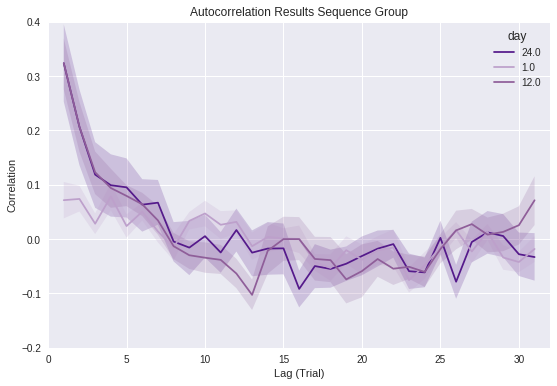

In [8]:
df1 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0006lags.csv'))
df2 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0012lags.csv'))
df3 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0192lags.csv'))
df4 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0273lags.csv'))
df5 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0490lags.csv'))
df6 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0491lags.csv'))
df7 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0557lags.csv'))
df8 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0558lags.csv'))
df9 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0559lags.csv'))
df1 = df1.append(df2)
df1 = df1.append(df3)
df1 = df1.append(df4)
df1 = df1.append(df5)
df1 = df1.append(df6)
df1 = df1.append(df7)
df1 = df1.append(df8)
df1 = df1.append(df9)
lag_names = ['lag' + str(i) for i in  range(1,32)]
df = pd.melt(df1, id_vars=["day", 'subject'], value_vars = lag_names )
df['Group'] = np.array('sequence')
df['variable'] = df['variable'].map(lambda x: x.lstrip('lag').rstrip('aAbBcC'))
df = df[(df.day == 1) | (df.day == 12) | (df.day == 24)]
df.to_csv(os.path.expanduser('~/Dropbox/test.csv'))
fig = plt.figure(figsize=(9,6))
colordict = {1:'#BDA0CB', 12:'#8F5E99', 24:'#551A8B'}
df = df.convert_objects(convert_numeric=True)
ax = sns.tsplot(time='variable', value='value',unit='subject', \
                condition="day",data=df,interpolate=True, 
                color =colordict, ci=68)
ax.set(xlabel='Lag (Trial)', ylabel='Correlation')
#     ax.set(title= 'Distance changes by group')
ax.set(xlim=(0, 32))
ax.set(ylim=(-.2, .4))
ax.set_title('Autocorrelation Results Sequence Group')
fig.savefig('/home/beukema2/Dropbox/r2d4/finalfigures/Figure2/sequence_autocorr.svg')                                                                                                                                           


/home/beukema2/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


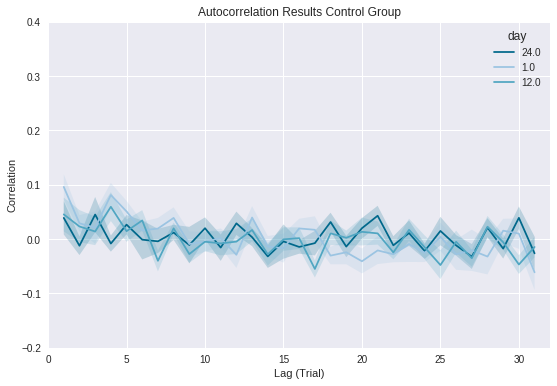

In [10]:
df1 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0269lags.csv'))
df2 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0464lags.csv'))
df3 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0494lags.csv'))
df4 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0495lags.csv'))
df5 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0549lags.csv'))
df6 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0550lags.csv'))
df7 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0604lags.csv'))
df8 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0605lags.csv'))
df9 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/acfTest/0627lags.csv'))
df1 = df1.append(df2)
df1 = df1.append(df3)
df1 = df1.append(df4)
df1 = df1.append(df5)
df1 = df1.append(df6)
df1 = df1.append(df7)
df1 = df1.append(df8)
df1 = df1.append(df9)
lag_names = ['lag' + str(i) for i in  range(1,32)]
df = pd.melt(df1, id_vars=["day", 'subject'], value_vars = lag_names )
df['Group'] = np.array('control')
df['variable'] = df['variable'].map(lambda x: x.lstrip('lag').rstrip('aAbBcC'))
df = df[(df.day == 1) | (df.day == 12) | (df.day == 24)]
fig = plt.figure(figsize=(9,6))

colordict = {1:'#9BC4E2', 12:'#50A6C2', 24:'#00688B'}
df = df.convert_objects(convert_numeric=True)
ax = sns.tsplot(time='variable', value='value',unit='subject', \
                condition="day",data=df,interpolate=True, 
                color =colordict, ci=68)
ax.set(xlabel='Lag (Trial)', ylabel='Correlation')
ax.set(xlim=(0, 32))
ax.set(ylim=(-.2,.4))
ax.set_title('Autocorrelation Results Control Group')
fig.savefig('/home/beukema2/Dropbox/r2d4/finalfigures/Figure2/control_autocorr.svg')                                                                                                                                           


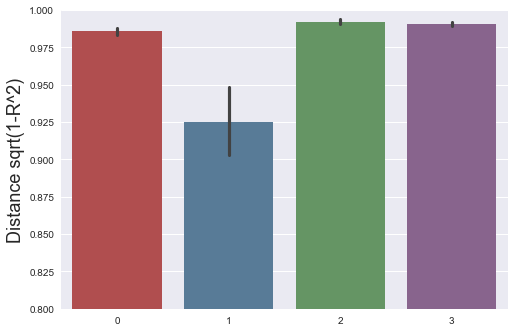

In [35]:
df = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure2/correlation_distances.csv'), header=None)
lm = sns.barplot(data=df, ci=68)
lm.set(ylim=(0.8, 1))
plt.ylabel('Distance sqrt(1-R^2)', fontsize=18)
plt.savefig(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure2/distances.svg'))                                                                                                                                           


## <center> Effector Distance Plots 

In [15]:
df = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure2/effectorDistance_sequence.csv'))

df = pd.melt(df, id_vars=["Day"], var_name="subject")
df['Group'] = np.array('sequence')
df2 = pd.read_csv(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure2/effectorDistance_control.csv'))

df2 = pd.melt(df2, id_vars=["Day"], var_name="subject")
df2['Group'] = np.array('random')
bigdata=df.append(df2,ignore_index = True)
plt.figure(figsize=[8,6])
ax = sns.tsplot(data=bigdata, time="Day", unit="subject",ci=68, value="value", condition="Group",estimator=np.nanmean, interpolate = True, color=['#848BB6', '#3498DB'])
ax.set(xlabel='Day', ylabel='Distance between effectors')
ax.set(title= 'Effector Distance')
ax.set(ylim=(0.8, 1.0))
plt.savefig(os.path.expanduser('~/Dropbox/r2d4/finalfigures/Figure2/effectDistance.svg'))


KeyError: 'Day'

## remake Summaries for ACF plots

In [ ]:
-